## Section 1. Libraries

In [1]:
import numpy
import matplotlib.pyplot
import sys
import os
import torch
import yaml
import pandas

sys.path.append(os.path.join(sys.path[0], '../'))

from src.proposed_method.explainable_NN import explainable_NN
from src.utils.load_data import load_data
from src.utils.utils_proposed_method import search_counterfactuals
from src.utils.metrics_functions import compute_metrics

from src.cost_policy.cost_policy_for_datasets import funcion_costes_numpy, funcion_costes_torch
%load_ext autoreload
%autoreload 2

## Section 2. Load params from yaml

In [2]:
with open('../conf/proposed_method_params.yaml') as f:
    params = yaml.load(f, Loader=yaml.loader.SafeLoader)

########## Paths ##########
path_save_counterfactual = "../results/re-computing_counterfactual_explanations/"
path_precomputed_counterfactuals = "../results/pre-computed_counterfactual_explanations/"
path_pretrained_model = "../data/pretrained_clasification_models/"
path_data = "../data/datasets/"
###########################

## Compute the metrics and results table from pre-searched counterfactuals

If you want to compute the results of the RE-computed counterfactuals you must to change the variable 'use_precomputed_counterfactuals' from True to False.

***[WARNING]***: This just modify the path where to load the counterfactuals, but the folder "re-computed_counterfactual_explanations" is empty by default. To re-compute the experiments you must re-execute the desired experiments with the **Section 3** of this notebook.

Also if necesary, you can comment some names in the variables 'dataset_name_list' and 'model_name_list' in case you only want to compute the metrics for a specific combination of dataset and/or explanation method.

In [3]:
########### Modificable params ###########
dataset_name_list = [  # Comment any dataset to not compute the metrics of its counterfactuals.
                     'HMEQ',
                     'TCC',
                     'CCF',
                     'MKT',
                     'CS1',
                     'CS2',
                     ]
method_name_list = [  # Comment any method to not compute the metrics of its counterfactuals.
                    'Proposed',
                    'Alibi_proto',
                    'Alibi_cem',
                    'GRACE'
                    ]
use_precomputed_counterfactuals = True  # Change to False for compute metrics of RE-computed counterfactuals.
verbose = False
##########################################

if use_precomputed_counterfactuals:
    # To compute the resulting metrics of the PRE-computed counterfactuals
    load_experiments_path = path_precomputed_counterfactuals
else:
    # To compute the resulting metrics of the RE-computed counterfactuals
    load_experiments_path = path_save_counterfactual

final_results = compute_metrics(method_name_list=method_name_list,
                                dataset_name_list=dataset_name_list,
                                load_experiments_path=load_experiments_path,
                                verbose=verbose)

global_mean_orig_distance = final_results['global_mean_orig_distance']
global_mean_plausible_distance = final_results['global_mean_plausible_distance']
global_succeed_ratio = final_results['global_succeed_ratio']
global_counter_savings = final_results['global_counter_savings']
global_results_dict = final_results['global_results_dict']

print("\n\n[Table Results]: Counter Savings")
display(pandas.DataFrame(global_counter_savings).transpose())

print("\n\n[Table Results]: Success Ratio")
display(pandas.DataFrame(global_succeed_ratio).transpose())

print("\n\n[Table Results]: Mean Orig Distance")
display(pandas.DataFrame(global_mean_orig_distance).transpose())

print("\n\n[Table Results]: Mean PLausible Distance")
display(pandas.DataFrame(global_mean_plausible_distance).transpose())



[Table Results]: Counter Savings


,HMEQ,TCC,CCF,MKT,CS1,CS2
Proposed,82.39,62.16,99.60,54.58,98.15,90.07
Alibi_proto,47.92,27.20,55.03,31.75,46.22,16.64
Alibi_cem,47.63,41.75,21.13,17.51,40.11,15.15
GRACE,44.10,26.02,46.19,13.18,52.49,12.61




[Table Results]: Success Ratio


,HMEQ,TCC,CCF,MKT,CS1,CS2
Proposed,99.63,100.00,99.19,82.73,92.63,81.36
Alibi_proto,95.15,100.00,100.00,96.28,95.39,100.00
Alibi_cem,80.22,100.00,34.15,80.93,87.01,100.00
GRACE,84.70,3.39,52.85,76.81,85.93,98.97




[Table Results]: Mean Orig Distance


,HMEQ,TCC,CCF,MKT,CS1,CS2
Proposed,0.57 ± 0.47,2.68 ± 0.63,7.99 ± 5.14,2.33 ± 1.85,1.02 ± 4.97,9.77 ± 8.28
Alibi_proto,0.98 ± 1.09,0.82 ± 0.46,9.56 ± 6.57,2.06 ± 1.1,0.33 ± 1.44,0.46 ± 0.37
Alibi_cem,0.92 ± 1.91,0.92 ± 0.42,0.99 ± 2.1,0.61 ± 0.51,0.45 ± 1.46,0.44 ± 0.33
GRACE,3.15 ± 5.74,0.3 ± 0.19,3.78 ± 5.16,1.24 ± 0.94,28.76 ± 74.4,0.46 ± 0.45




[Table Results]: Mean PLausible Distance


,HMEQ,TCC,CCF,MKT,CS1,CS2
Proposed,2.29 ± 1.7,3.1 ± 0.78,12.2 ± 9.42,2.41 ± 1.81,0.91 ± 3.71,8.5 ± 7.52
Alibi_proto,1.88 ± 1.17,1.62 ± 0.97,9.03 ± 5.33,1.67 ± 0.73,0.34 ± 0.38,0.83 ± 0.77
Alibi_cem,2.72 ± 2.11,1.85 ± 1.05,13.83 ± 10.8,0.7 ± 0.65,0.52 ± 0.96,0.87 ± 0.83
GRACE,3.93 ± 4.5,1.45 ± 1.18,14.01 ± 10.47,1.33 ± 0.96,17.71 ± 50.75,0.88 ± 0.88


## [Optional]  Section 3. Reproduce the counterfactual searching over all datasets

**[Warning]** This may take a high amount of time depending on the dataset. An aproximation of the duration of the search of each dataset is:
- HMEQ:
- TCC: 4 min
- MKT:
- CS1:
- CS2:

**[Important]** Due to the execution times, we carefully recoment to reproduce the experiments one by one. This can be perform just by only leave one dataset name uncommented in the 'list_datasets' variable in the next cell.



__________________________________________________
Searching Counterfactuals on CCF dataset

[Process] START data loading
[Data Info] Imbalance ratio (IR) = P0/P1 = N0/N1 || total: 57.8	 || tr: 57.8	 || ts: 57.8
[Data Info] mean(1/Qc = (c01 - c11)/(c10 - c00)) || total: 14.9	 || tr: 14.9	 || ts: 14.9
[Data Info] shape: 29 dims for 28922 samples || Train/Test = 75/25 [%]
[Process] DONE data loading


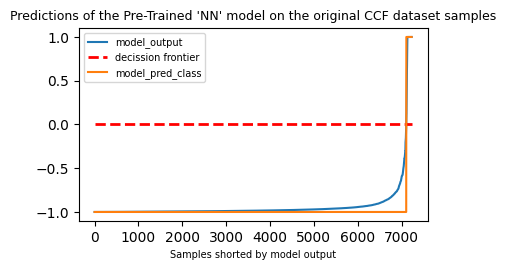


[Process] START counterfactual search


  0%|          | 0/123 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [5]:
########### Modificable params ###########
dataset_name_list = [  # Comment any dataset to not compute the metrics of its counterfactuals.
                     'MKT',
                     'TCC',
                     'CCF',
                     'HMEQ',
                     'CS1',
                     'CS2',
                     ]
save_results = True
verbose = 1  # [0: no prints; 1: high level information; 2: full detail]. [Warning] there is a level 3, but it saturates the output console
             # so if necesary, just use it for a single sample on a single dataset.
figure = False  # [Warning]: This params displays a set of charts by each sample of each dataset.
#                 Just activate then executing with a small amount of samples on a single dataset.
plot_resume_of_dataset_outputs = True
small_test = True
##########################################

for name_dataset in dataset_name_list:

    print("\n")
    print("__________________________________________________")
    print(f"Searching Counterfactuals on {name_dataset} dataset")
    loaded_dataset = load_data(name_dataset=name_dataset,
                               path_data=path_data,
                               verbose=verbose)

    ############ Create explainable model ############
    # Load pretrained NN weights
    file_load_NN_weights = f"{name_dataset}_NN_weights.txt"
    direccion_resultado = path_pretrained_model + file_load_NN_weights
    weights_pretrained_model = torch.load(direccion_resultado)

    # Initializing the NN model with the pretrained NN params
    tensor_x_ts = loaded_dataset['tensor_x_ts']
    explainable_NN_model = None
    explainable_NN_model = explainable_NN(name_dataset=name_dataset, 
                                        pretrained_weights=weights_pretrained_model,
                                        input_size=tensor_x_ts.shape[1],
                                        hidden_size=params[name_dataset]['NN']
                                        )
    ##################################################

    if plot_resume_of_dataset_outputs:
        prob_pred_orig_ts = explainable_NN_model.eval_samples(tensor_x_ts).detach().numpy().flatten()
        y_pred_orig_ts = explainable_NN_model.predict_class(x_input=tensor_x_ts).astype(int)

        index_sort = prob_pred_orig_ts.argsort()
        x_max = y_pred_orig_ts.sum()
        matplotlib.pyplot.figure(figsize=(4.5,2.5))
        matplotlib.pyplot.plot(prob_pred_orig_ts[index_sort], label='model_output')
        matplotlib.pyplot.hlines(y=0.0, xmin=0, xmax=len(y_pred_orig_ts), linewidth=2, colors='r', linestyles='--', label='decission frontier')
        matplotlib.pyplot.plot(y_pred_orig_ts[index_sort], label='model_pred_class')
        matplotlib.pyplot.xlabel('Samples shorted by model output', fontsize=7)
        matplotlib.pyplot.title(f"Predictions of the Pre-Trained 'NN' model on the original {name_dataset} dataset samples", fontsize=9)
        matplotlib.pyplot.legend(fontsize=7)
        matplotlib.pyplot.show()

    results = search_counterfactuals(name_dataset=name_dataset,
                                     explainable_NN_model=explainable_NN_model,
                                     loaded_dataset=loaded_dataset,
                                     params=params,
                                     figure=figure,
                                     verbose=verbose,
                                     small_test=small_test)
    print("__________________________________________________")
    if save_results:
        file_save_counterfactuals = f"counterfactual_results_{name_dataset}"
        direccion_resultado  = path_save_counterfactual + "Proposed/" + file_save_counterfactuals
        numpy.save(direccion_resultado, results, allow_pickle=True)
